Retrieves images from "full_imgs" and stores each VOI separately in "train_imgs". Retrieves spreadsheet listing VOIs and stores them in text file. Requires data-retrieval to be run first.

In [7]:
import config
import helper_fxns as hf
import transforms as tr
import importlib
import numpy as np
import os
import requests
import sys
import copy
import math
import pandas as pd
import random
import matplotlib.pyplot as plt
import time
%matplotlib inline

with open("train_list.txt", "r") as f:
    vois = [x.split(',') for x in f.read().split("\n")]

voi_df = pd.DataFrame(vois, columns = ["Filename", "x1", "x2", "y1", "y2", "z1", "z2", "cls"]).dropna()
voi_df = voi_df.astype({"x1": int, "x2": int, "y1": int, "y2": int, "z1": int, "z2": int})

voi_df['dx'] = voi_df.apply(lambda row: row['x2'] - row['x1'], axis=1)
voi_df['dy'] = voi_df.apply(lambda row: row['y2'] - row['y1'], axis=1)
voi_df['dz'] = voi_df.apply(lambda row: row['z2'] - row['z1'], axis=1)

In [9]:
C = config.Config()
final_size = C.dims

voi_df = pd.read_csv('vois.csv')

In [3]:
def augment(img, final_size, num_samples = 100, translate=None):
    aug_imgs = []
    
    for _ in range(num_samples):
        temp_img = img
        angle = random.randint(0, 359)
        temp_img = tr.rotate(temp_img, angle)
        
        #scales = [0.9, 1.1]
        #scale = [random.uniform(scales[0],scales[1]), random.uniform(scales[0],scales[1]), random.uniform(scales[0],scales[1])]
        #temp_img = tr.scale3d(temp_img, scale)
        
        if translate is not None:
            trans = [random.randint(-translate[0], translate[0]),
                     random.randint(-translate[1], translate[1]),
                     random.randint(-translate[2], translate[2])]
        else:
            trans = [0,0,0]
        
        flip = [random.choice([-1, 1]), random.choice([-1, 1]), random.choice([-1, 1])]
        
        crops = [temp_img.shape[i] - final_size[i] for i in range(3)]
        
        aug_imgs.append(temp_img[math.floor(crops[0]/2)*flip[0] + trans[0] : -math.ceil(crops[0]/2)*flip[0] + trans[0] : flip[0],
                                 math.floor(crops[1]/2)*flip[1] + trans[1] : -math.ceil(crops[1]/2)*flip[1] + trans[1] : flip[1],
                                 math.floor(crops[2]/2)*flip[2] + trans[2] : -math.ceil(crops[2]/2)*flip[2] + trans[2] : flip[2], :])
    
    return aug_imgs

In [4]:
def extract_voi(img, voi, final_size, aug=False):
    """Input: image, a voi from the image (as pd.Series), target size in voxels, and whether to augment.
    Outputs list of images (np.ndarray) and list of classes (string).
    Assumes that there is no voi so close to the edge that getting a volume of size final_size would make it go out of bounds.
    """
    voi_imgs = []
    classes = []
    
    # if augmenting, take a larger volume from the original image so rotating it will not cut off any part
    if aug:
        crop_size = [math.ceil(x*math.sqrt(2)) for x in final_size]
    else:
        crop_size = final_size
    
    exceed_ratio = max(voi['dx']/crop_size[0], voi['dy']/crop_size[1], voi['dz']/crop_size[2], 1) / 1

    # downscale image until it fits in final_size and cannot be cut off by rotation
    if exceed_ratio > 1:
        temp_img = tr.scale3d(img, [1/exceed_ratio]*3)
        x1 = round(voi['x1'] / exceed_ratio)
        x2 = round(voi['x2'] / exceed_ratio)
        y1 = round(voi['y1'] / exceed_ratio)
        y2 = round(voi['y2'] / exceed_ratio)
        z1 = round(voi['z1'] / exceed_ratio)
        z2 = round(voi['z2'] / exceed_ratio)
        dx = x2 - x1
        dy = y2 - y1
        dz = z2 - z1
    else:
        temp_img = copy.deepcopy(img)
        x1 = voi['x1']
        x2 = voi['x2']
        y1 = voi['y1']
        y2 = voi['y2']
        z1 = voi['z1']
        z2 = voi['z2']
        dx = x2 - x1
        dy = y2 - y1
        dz = z2 - z1
        
    xpad = max(crop_size[0] - dx,0)
    ypad = max(crop_size[1] - dy,0)
    zpad = max(crop_size[2] - dz,0)

    """plt.subplot(121)
    plt.imshow(np.transpose(img[voi['x1']:voi['x2'],
                                voi['y2']:voi['y1']:-1,
                                (voi['z1']+voi['z2'])//2, 0], (1,0)), cmap='gray')"""

    side_padding = math.ceil(max(xpad, ypad, zpad) / 2)

    pad_img = []

    for ch in range(temp_img.shape[-1]):
        pad_img.append(np.pad(temp_img[:,:,:,ch], side_padding, 'constant'))

    pad_img = np.stack(pad_img, axis=3)

    x1 += side_padding - math.ceil(xpad/2)
    x2 += side_padding + math.floor(xpad/2)
    y1 += side_padding - math.ceil(ypad/2)
    y2 += side_padding + math.floor(ypad/2)
    z1 += side_padding - math.ceil(zpad/2)
    z2 += side_padding + math.floor(zpad/2)

    pad_img = pad_img[x1:x2, y1:y2, z1:z2, :]
        
    if aug:
        aug_imgs = augment(pad_img, final_size, translate=[1,1,0], num_samples = 50)
        voi_imgs = voi_imgs + aug_imgs
        classes = classes + [voi['cls']] * len(aug_imgs)

    else:
        voi_imgs = [pad_img]
        if voi_imgs[0].shape[0] != final_size[0] or voi_imgs[0].shape[1] != final_size[1] or voi_imgs[0].shape[2] != final_size[2]:
            print(voi)
            print(x1,x2,y1,y2,z1,z2)
            print(voi_imgs[0].shape, final_size, zpad)
            raise ValueError("zzz")
        
        classes = [voi['cls']]

    """img = pad_img
    plt.subplot(122)
    plt.imshow(np.transpose(img[voi['x1']:voi['x2'],
                                voi['y2']:voi['y1']:-1,
                                (voi['z1']+voi['z2'])//2, 1], (1,0)), cmap='gray')"""
        
    return voi_imgs, classes

In [10]:
aug=True
t = time.time()

if not os.path.exists(C.aug_dir):
    os.makedirs(C.aug_dir)
if not os.path.exists(C.orig_dir):
    os.makedirs(C.orig_dir)
    
# iterate over image series
for img_fn in os.listdir("full_imgs\\"):
    img = np.load("full_imgs\\"+img_fn)
    vois = voi_df[voi_df["Filename"] == img_fn]
    
    # iterate over each voi in that image
    for voi_num, voi in enumerate(vois.iterrows()):
        cropped_imgs, classes = extract_voi(img, copy.deepcopy(voi[1]), final_size, aug=aug)

        if not os.path.exists(C.orig_dir+classes[0]):
            os.makedirs(C.orig_dir+classes[0])
        if not os.path.exists(C.aug_dir+classes[0]):
            os.makedirs(C.aug_dir+classes[0])

        for i in range(len(cropped_imgs)):
            np.save(C.aug_dir+classes[i]+"\\"+img_fn[:-4]+"_"+str(voi_num)+"_"+str(i), cropped_imgs[i])
    
        # save unaugmented vois as well
        if aug:
            cropped_imgs, classes = extract_voi(img, copy.deepcopy(voi[1]), final_size, aug=False)
            i = 0
            fn_stem = C.orig_dir+classes[i]+"\\"+img_fn[:-4]+"_"
            while os.path.exists(fn_stem + str(i) + ".npy"):
                i += 1
            np.save(fn_stem + str(i), cropped_imgs[0])
        
        if voi_num % 20 == 0:
            print(".", end="")
print("") 
print(time.time()-t)

................................................................................................................................................................
102.07272434234619


for x in os.listdir("train_imgs\\hcc\\"):
    if x[-6] != "_" and int(x[-6:-4]) > 30:
        os.remove("train_imgs\\hcc\\" + x)

[x for x in os.listdir("train_imgs\\hcc\\") if x[-6] != "_" and int(x[-6:-4]) > 30]

os.listdir("train_imgs\\hcc")[3]

In [ ]:
img = np.load("train_imgs\\cyst\\E100529980_1.npy")
#img = np.load("train_imgs\\cyst\\12302576_70.npy")
plt.imshow(img[:,:,5,0], cmap='gray')

In [3]:
def plot_section(img, df, pad=30):
    plt.subplot(121)
    plt.imshow(np.transpose(img[df['x1']-pad:df['x2']+pad,
                                df['y2']+pad:df['y1']-pad:-1,
                                (df['z1']+df['z2'])//2, 0], (1,0)), cmap='gray')
    plt.subplot(122)
    plt.imshow(np.transpose(img[df['x1']-pad:df['x2']+pad,
                                df['y2']+pad:df['y1']-pad:-1,
                                (df['z1']+df['z2'])//2, 1], (1,0)), cmap='gray')

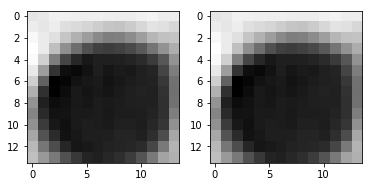

In [62]:
img_fn = "E100529980.npy"
img = np.load("full_imgs\\"+img_fn)
plot_section(img, voi_df[voi_df["Filename"] == img_fn].iloc[0], pad=0)